This is associated with this Twitter thread: https://twitter.com/AaronMcDaid/status/1526562786268127235

For AB testing, I've investigated a method to reduce the variance of estimates produced
according to Susan Athey's _"Estimating Treatment Effects using Multiple Surrogates: The Role of the Surrogate Score and the Surrogate Index"_

_Athey et al's "Estimating Treatment Effects using Multiple Surrogates: The Role of the Surrogate Score and the Surrogate Index" (2020)_ ([arXiv](https://arxiv.org/abs/1603.09326)).

A thread to explain and justify it, closing with simulations.

First, I state the standard method, and then define my variance-reducing extension.

I think my extension is novel; has someone else tried this?

After running an AB test for one month, we have estimates of the treatment effect on the revenue over one month, and also on other variables recording the users' activity over one month. These "short term" variables are called "surrogates".

We'd like to know the effect on long-term (e.g. 1 year) revenue, but we don't want to run the AB test for one year. If we have historical customer records going back multiple years, we can build a predictor for 1-year revenue that makes predictions based on just one month of data. The predictor can also use pre-treatment variables as regressor variables.

Then, immediately after our 1-month experiment, we use the surrogates and the pre-treatment variables and feed them through the predictor. Finally, we estimate the treatment effect from these _predicted_ 1-year revenues.

This completes the discussion of the standard method. You must read the (excellent) paper by Athey et al if you want to use this for real; I haven't mentioned the critically important assumptions (Ignorability, Surrogacy, Comparability) that are needed for unbiased estimates.

Before introducing my extension, I'll formally restate the standard method.
In the historical dataset, we can estimate $Y$ as a function of $S, X$,
this gives us our prediction function $h(S, X)$.
Immediately after the AB test finishes, we gather the S and X and compute
the predictions $a_i = h(S_i, X_i)$.
We then compare the $a$ for the Control group (W=0) to the Treatment
Group (W=1), perhaps via a Student's t-test.
We don't know the true $Y_i$ immediately after the AB test finishes, as we're not patient
enough to let it run for one year, so we use the $a_i$ in place the $Y_i$.

$$ W_i \in\{0,1\} : \mbox{ treatment indicator for customer $i$} $$
$$ X_i : \mbox{ pre-treatment covariates for customer $i$} $$
$$ S_i : \mbox{ surrogates for customer $i$ } $$
$$ Y_i : \mbox{ long term revenue for customer $i$ } $$
$$ a_i : \mbox{ the prediction (of $Y_i$) for customer $i$ } $$

$$ \hat\Delta = \frac{\sum_i W_i a_i}{\sum_i W_i} - \frac{\sum_i (1-W_i)a_i}{\sum_i (1-W_i)} $$

Finally, my proposal: compute a second predictor which uses exclusively pre-treatment variables. i.e. h'(X).
Then, for each customer after the experiment we compute both predictions and subtract them as follows

$$ b_i = h(S_i, X_i) - h'(X_i) $$

We then use the b instead of the a for our estimate. This works because the $-h'(X_i)$ is independent of the treatment - it's computed exclusively from pre-treatment variables.

$$ \hat\Delta_{reduced\;variance} = \frac{\sum_i W_i b_i}{\sum_i W_i} - \frac{\sum_i  (1-W_i) b_i }{\sum_i (1-W_i)} $$
$$ \hat\Delta_{reduced\;variance} = \hat\Delta - \overbrace{\Big( \frac{\sum_i W_i h'(X_i)}{\sum_i W_i} - \frac{\sum_i (1-W_i) h'(X_i)}{\sum_i (1-W_i)} \Big)}^{\mbox{mean zero, as $h'(X_i) ⫫ W_i$, hence no bias}} $$

The estimates h'(X_i) won't be as accurate as the h(S_i, X_i) estimates, but they should be better
than nothing - presuming that X_i contains some information about Yᵢ - and the estimates from h and from h' will generally be positively correlated with each other, therefore the variance will be reduced in typical applications.

Finally, a simple simulation to demonstrate this.
Following the notation of _Athey et al's "Estimating Treatment Effects using Multiple Surrogates: The Role of the Surrogate Score and the Surrogate Index" (2020)_ ([arXiv](https://arxiv.org/abs/1603.09326)).

- W is the random assignment into one of two groups (Control and Treatment)
- X is a per-customer pre-treatment covariate.
- S are per-customer post-treatment variables.

Link to this notebook: https://github.com/aaronmcdaid/aaronmcdaid.github.io/blob/main/notebooks/AtheySurrogates/Reducing%20the%20variance%20of%20surrogate-index%20estimates.ipynb

$$ W_i \sim Bernoulli(0.5) $$
$$ X_i \sim Normal(0, 1) $$
$$ S^{(1)}_i \sim Normal(\beta_1 W_i + X_i, 1) $$
$$ S^{(2)}_i \sim Normal(\beta_2 W_i          , 1) $$
$$ Y_i \sim Normal(\beta_0 S^{(1)} + \beta_0 S^{(2)} + \gamma X_i, 1) $$

<center>
The true ATE, i.e. the effect of W_i on Y_i, is $\beta_1 \beta_0 + \beta_2 \beta_0$
</center>

Here is a DAG for this AB test, with causality flowing downwards:
```
 X      W
 |\    /|
 | \  / |
 |  \/  |
 |  S1  S2
  \  |  /
   \ | /
    \|/
     Y
```

In the historical dataset, we don't have W:

```
 X       
 |\      
 | \
 |  \
 |  S1  S2
  \  |  /
   \ | /
    \|/
     Y
```

When simulating the historical dataset, we don't need to worry about how $X$, $S_1$, or $S_2$ are generated.
We just need to respect the _Comparability Assumption_, i.e. $\mathbb{E}(Y|X, S_1, S_2)$ must be the same in both. In these simple simulations, we do this by generating Y as a random function of those three (and of nothing else).

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

First, a simple function to simulate one AB test. This also involves simulating a corresponding historical dataset.

In [2]:
def simulate_one_experiment(spec_historical: str, spec_experimental: str, seed: int, **params):
    np.random.seed(seed)

    return (
        pd.DataFrame().eval(spec_historical, local_dict=params),
        pd.DataFrame().eval(spec_experimental, local_dict=params),
    )

df_h, df_e = simulate_one_experiment(
    """
        X = @stats.norm().rvs(@N_h)
        S_1 = X                            + @stats.norm().rvs(@N_h)
        S_2 =                              + @stats.norm().rvs(@N_h)
        Y   = @beta_0 * S_1 + @beta_0 * S_2 + @gamma * X + @stats.norm().rvs(@N_h)
    """,
    """
        W = @stats.bernoulli(p=0.5).rvs(@N_e)
        X = @stats.norm().rvs(@N_e)
        S_1 = @beta_1 * W + X                            + @stats.norm().rvs(@N_e)
        S_2 = @beta_2 * W                                + @stats.norm().rvs(@N_e)
        Y   = @beta_0 * S_1 + @beta_0 * S_2 + @gamma * X + @stats.norm().rvs(@N_e)
        true_effect = @beta_0 * (@beta_1+@beta_2)
    """,
    N_h = 3000,
    N_e = 2000,
    seed = 1337,
    beta_0 = 2,
    beta_1 = 3,
    beta_2 = 5,
    gamma = 1,
)

display(df_h)
display(df_e)

,X,S_1,S_2,Y
0,-0.703187,-1.154499,0.990498,-1.020883
1,-0.490282,-1.957285,-1.676590,-6.956100
2,-0.321814,-0.049202,-0.350337,-2.043949
3,-1.755079,-0.961581,0.745607,-2.895855
4,0.206664,1.469877,0.498049,1.912568
...,...,...,...,...
2995,0.882416,1.564831,-1.427541,0.843397
2996,-0.830941,-1.989958,-0.033103,-4.112922
2997,-0.473889,-0.406186,0.688146,-1.045368
2998,-0.596884,-0.329991,0.414513,-2.141690


,W,X,S_1,S_2,Y,true_effect
0,1,0.166258,2.294647,5.955592,14.153087,16
1,0,0.700823,-0.272297,0.670237,2.278508,16
2,1,0.251386,3.898421,5.425614,18.001371,16
3,1,1.775726,6.468154,4.070751,23.055638,16
4,1,-0.636728,1.406303,5.165335,12.065029,16
...,...,...,...,...,...,...
1995,0,-0.971086,-1.812359,0.857269,-3.619978,16
1996,0,-1.562083,-0.913598,-0.108766,-2.470965,16
1997,1,0.920501,5.134940,6.267357,24.289155,16
1998,1,1.738312,5.819539,5.106788,24.142736,16


In [3]:
import sys
!{sys.executable} -m pip install sklearn

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
def compute_many_estimates(df_h, df_e):
    true_effect, = set(df_e.true_effect)
    
    # The standard method: estimate h(S,X) and make predictions from that:
    reg=LinearRegression().fit(df_h[['X', 'S_1', 'S_2']], df_h.Y)
    preds = reg.predict(df_e[['X', 'S_1', 'S_2']])
    
    # variance-reduced
    non_surrogate_reg=LinearRegression().fit(df_h[['X']], df_h.Y)
    non_surrogate_preds = non_surrogate_reg.predict(df_e[['X']])
    
    simple, = LinearRegression().fit(df_e[['W']], preds).coef_
    mean_zero, = LinearRegression().fit(df_e[['W']], non_surrogate_preds).coef_
    variance_reduced, = LinearRegression().fit(df_e[['W']], preds - non_surrogate_preds).coef_
    return pd.DataFrame(
        dict(
            true_effect = [true_effect],
            simple = [simple],
            mean_zero = [mean_zero],
            variance_reduced = [variance_reduced],
        )
    )
    
compute_many_estimates(df_h, df_e)

,true_effect,simple,mean_zero,variance_reduced
0,16,16.269573,0.229419,16.040155


In [6]:
import matplotlib.pyplot as plt

In [7]:
results = pd.concat([
    compute_many_estimates(df_h, df_e)
    for seed in range(1337, 1337+100)
    for df_h, df_e in [
        simulate_one_experiment(
            """
                X = @stats.norm().rvs(@N_h)
                S_1 = X                            + @stats.norm().rvs(@N_h)
                S_2 =                              + @stats.norm().rvs(@N_h)
                Y   = @beta_0 * S_1 + @beta_0 * S_2 + @gamma * X + @stats.norm().rvs(@N_h)
            """,
            """
                W = @stats.bernoulli(p=0.5).rvs(@N_e)
                X = @stats.norm().rvs(@N_e)
                S_1 = @beta_1 * W + X                            + @stats.norm().rvs(@N_e)
                S_2 = @beta_2 * W                                + @stats.norm().rvs(@N_e)
                Y   = @beta_0 * S_1 + @beta_0 * S_2 + @gamma * X + @stats.norm().rvs(@N_e)
                true_effect = @beta_0 * (@beta_1+@beta_2)
            """,
            N_h = 3000,
            N_e = 2000,
            seed = seed,
            beta_0 = 2,
            beta_1 = 3,
            beta_2 = 5,
            gamma = 10,
        )
    ]
])
results

,true_effect,simple,mean_zero,variance_reduced
0,16,16.960246,0.920091,16.040155
0,16,17.101493,0.902072,16.199421
0,16,16.923131,0.658087,16.265043
0,16,15.715646,-0.178489,15.894135
0,16,16.041819,0.042501,15.999318
...,...,...,...,...
0,16,16.470690,0.458770,16.011920
0,16,15.805158,-0.009698,15.814856
0,16,15.518300,-0.325423,15.843723
0,16,16.192711,0.278141,15.914570


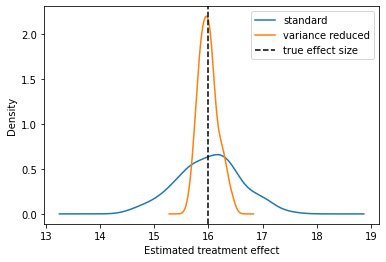

In [8]:
results.simple.plot(kind='density', label='standard')
results.variance_reduced.plot(kind='density', label='variance reduced')

# Identify the true effect size, so we can mark it
true_effect, = set(results.true_effect)
plt.axvline(x=true_effect, color='black', label = 'true effect size', ls='dashed')
plt.xlabel('Estimated treatment effect')
plt.legend();

This looks good, but of course we get different results if the simulation parameters are changed.
As discussed, if $X$ is useless at predicting the long-term outcome - which we can simulate here by settings $\gamma=0$ - then the variance isn't reduced. But I suspect this isn't an issue in typical AB tests; i.e. long term revenue surely has some non-negligible correlation with the users' pre-experiment revenue.

In [9]:
results = pd.concat([
    compute_many_estimates(df_h, df_e)
    for seed in range(1337, 1337+100)
    for df_h, df_e in [
        simulate_one_experiment(
            """
                X = @stats.norm().rvs(@N_h)
                S_1 = X                            + @stats.norm().rvs(@N_h)
                S_2 =                              + @stats.norm().rvs(@N_h)
                Y   = @beta_0 * S_1 + @beta_0 * S_2 + @gamma * X + @stats.norm().rvs(@N_h)
            """,
            """
                W = @stats.bernoulli(p=0.5).rvs(@N_e)
                X = @stats.norm().rvs(@N_e)
                S_1 = @beta_1 * W + X                            + @stats.norm().rvs(@N_e)
                S_2 = @beta_2 * W                                + @stats.norm().rvs(@N_e)
                Y   = @beta_0 * S_1 + @beta_0 * S_2 + @gamma * X + @stats.norm().rvs(@N_e)
                true_effect = @beta_0 * (@beta_1+@beta_2)
            """,
            N_h = 3000,
            N_e = 2000,
            seed = seed,
            beta_0 = 2,
            beta_1 = 3,
            beta_2 = 5,
            gamma = 0, # No *direct* effect of X on Y
        )
    ]
])
results

,true_effect,simple,mean_zero,variance_reduced
0,16,16.192832,0.152677,16.040155
0,16,16.346657,0.147236,16.199421
0,16,16.371688,0.106644,16.265043
0,16,15.865496,-0.028640,15.894135
0,16,16.006601,0.007283,15.999318
...,...,...,...,...
0,16,16.089064,0.077144,16.011920
0,16,15.813217,-0.001639,15.814856
0,16,15.787617,-0.056106,15.843723
0,16,15.961154,0.046584,15.914570


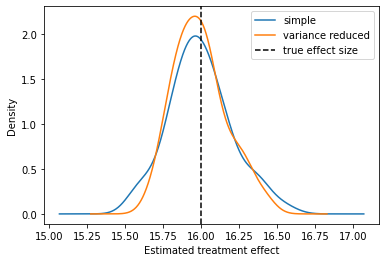

In [10]:
results.simple.plot(kind='density', label='simple')
results.variance_reduced.plot(kind='density', label='variance reduced')

# Identify the true effect size, so we can mark it
true_effect, = set(results.true_effect)
plt.axvline(x=true_effect, color='black', label = 'true effect size', ls='dashed')
plt.xlabel('Estimated treatment effect')
plt.legend();